<a href="https://colab.research.google.com/github/gabrielcarcedo/SargazoClassification_ViT/blob/main/MeIA_Sargazo_Clasificaci%C3%B3n_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
import torch
from transformers import ViTImageProcessor
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from transformers import ViTForImageClassification
from torch.optim import AdamW
import time
import torch.nn.functional as F
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/MeIA Sargazo Dataset/

/content/drive/MyDrive/MeIA Sargazo Dataset


In [ ]:
!ls

images	resized_images		    ViT_train_stats.csv
labels	ViT_checkpoints_2025_06_17  ViT_val_stats.csv


In [ ]:
df_train = pd.read_csv('labels/labels_augmented.csv')
df_test = pd.read_csv('labels/test.csv')
print(df_train.shape)
print(df_test.shape)

(6204, 6)
(150, 3)


In [ ]:
images_list = os.listdir('resized_images')
print(len(images_list))

6354


In [ ]:
images_train = df_train['image_name'].tolist()
images_test = df_test['image_name'].tolist()

images_train = ['resized_images/' + image for image in images_train]
images_test = ['resized_images/' + image for image in images_test]

print(len(images_train))
print(len(images_test))

6204
150


In [ ]:
df_train

,image_name,place,date,label,scene,label_num
0,i0001.jpg,Xpu-Ha,10/7/2022,nada,playa,0
1,i0002.jpg,Xpu-Ha,10/7/2022,nada,playa,0
2,i0003.jpg,Xpu-Ha,10/7/2022,bajo,playa,1
3,i0004.jpg,Xpu-Ha,10/7/2022,bajo,playa,1
4,i0005.jpg,Xpu-Ha,10/3/2022,bajo,playa,1
...,...,...,...,...,...,...
6199,s0577_saturation.jpg,Xcacel,4/12/2019,excesivo,playa,4
6200,s0577_brightness.jpg,Xcacel,4/12/2019,excesivo,playa,4
6201,s0577_contrast.jpg,Xcacel,4/12/2019,excesivo,playa,4
6202,s0577_rotation.jpg,Xcacel,4/12/2019,excesivo,playa,4


In [ ]:
df_test['label_num'] = np.zeros(len(df_test))
df_test.head()

,image_name,place,date,label_num
0,s0826.jpg,Akumal,8/4/2019,0.0
1,s0827.jpg,Akumal,8/4/2019,0.0
2,s0828.jpg,Playa del Carmen,8/3/2019,0.0
3,s0829.jpg,Mahahual,8/3/2019,0.0
4,s0830.jpg,Punta Venado Riviera Maya,8/3/2019,0.0


In [ ]:
images_train_label = df_train[['image_name', 'label_num']].values.tolist()
images_test_label = df_test[['image_name', 'label_num']].values.tolist()

# Clase para crear el dataset

In [ ]:
class FilenameMappedDataset(Dataset):
    def __init__(self, image_paths, filename_label_pairs, transform=None):
        self.image_paths = image_paths
        self.transform = transform

        # Crear un diccionario tipo: {'ID_0001.png': 0, 'ID_0002.jpg': 1, ...}
        self.label_map = {filename: label for filename, label in filename_label_pairs}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path)
        label = self.label_map[filename]  # Busca la clase asociada a este filename

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        #print(img_path.split('/')[-1], label)
        return image, label

In [ ]:
#@markdown ### Cargando procesador para transformaciones
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

transform_fn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_val, images_train_label, images_val_label = train_test_split(images_train, images_train_label, test_size=0.1, random_state=200)

print(len(images_train))
print(len(images_val))
print(len(images_test))

5583
621
150


In [ ]:
train_dataset = FilenameMappedDataset(images_train, images_train_label, transform=transform_fn)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = FilenameMappedDataset(images_val, images_val_label, transform=transform_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = FilenameMappedDataset(images_test, images_test_label, transform=transform_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

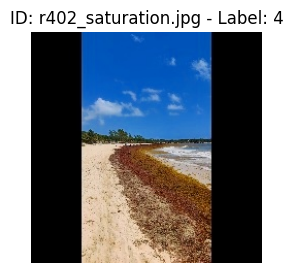

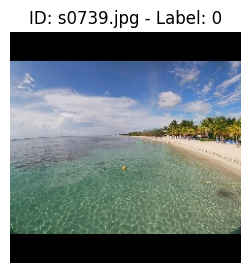

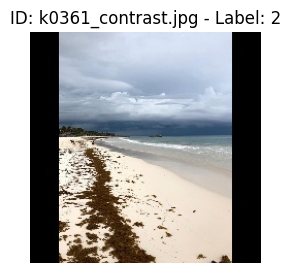

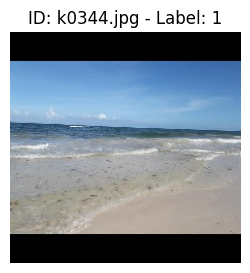

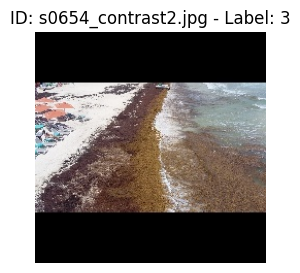

In [ ]:
simple_transform = transforms.ToTensor()
visual_dataset = FilenameMappedDataset(images_train, images_train_label, transform=simple_transform)

# Mostrar algunas muestras
for i in random.sample(range(len(visual_dataset)), 5):
    image, label = visual_dataset[i]
    plt.figure(figsize=(3, 3))
    plt.imshow(image.permute(1, 2, 0))  # cambia de [C, H, W] a [H, W, C]
    plt.title(f"ID: {images_train_label[i][0]} - Label: {label}")
    plt.axis('off')
    plt.show()

# Hiperparámetros

In [ ]:
# Configuración
num_epochs = 10
patience = 5
learning_rate = 2e-5
num_classes = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#folds = 5

In [ ]:
# Métricas
train_stats, val_stats = [], []

fecha = time.strftime("%Y_%m_%d")
checkpoint_dir = f"ViT_checkpoints_{fecha}"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
fecha = '2025_06_17'
checkpoint_dir = f"ViT_checkpoints_{fecha}"

In [ ]:
model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=num_classes
    )
# Ruta del mejor modelo
best_model_path = os.path.join(checkpoint_dir, f"ViT_best_model_.pth")
model.load_state_dict(torch.load(best_model_path, map_location=device))

model.to(device)

# Optimizador y función de pérdida
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_val_acc, patience_counter = 0.0, 0
for epoch in range(num_epochs):
    # ----- Entrenamiento -----
    epoch_train_start = time.time()
    model.train()

    running_loss, correct, total, running_sensitivity, running_specificity = 0.0, 0, 0, 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Convert labels to one-hot encoding
        labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels_one_hot) # Use one-hot encoded labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        tp = ((predicted == labels) & (labels == 1)).sum().item()
        tn = ((predicted == labels) & (labels == 0)).sum().item()
        fp = ((predicted != labels) & (labels == 0)).sum().item()
        fn = ((predicted != labels) & (labels == 1)).sum().item()
        running_sensitivity += tp / (tp + fn + 1e-8)
        running_specificity += tn / (tn + fp + 1e-8)
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_sensitivity = running_sensitivity / total
    train_specificity = running_specificity / total
    train_time = time.time() - epoch_train_start

    # ----- Validación -----
    epoch_val_start = time.time()
    model.eval()

    val_loss, val_correct, val_total, val_sensitivity, val_specificity = 0.0, 0, 0, 0.0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Convert labels to one-hot encoding
            labels_one_hot = torch.zeros(labels.size(0), num_classes).to(device)
            labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

            outputs = model(images).logits
            loss = criterion(outputs, labels_one_hot) # Use one-hot encoded labels

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            tp = ((predicted == labels) & (labels == 1)).sum().item()
            tn = ((predicted == labels) & (labels == 0)).sum().item()
            fp = ((predicted != labels) & (labels == 0)).sum().item()
            fn = ((predicted != labels) & (labels == 1)).sum().item()
            val_sensitivity += tp / (tp + fn + 1e-8)
            val_specificity += tn / (tn + fp + 1e-8)
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_sensitivity /= val_total
    val_specificity /= val_total
    val_time = time.time() - epoch_val_start

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    # Guardar si mejora la validación
    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"ViT_best_model_.pth"))
        print(f"Mejor modelo guardado en epoch {epoch+1} con val acc = {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en epoch {epoch+1} con val acc = {val_acc:.4f}")
            break

    # Registrar métricas
    train_stats.append([epoch+1, train_loss, train_acc, train_sensitivity, train_specificity, train_time])
    val_stats.append([epoch+1, val_loss, val_acc, val_sensitivity, val_specificity, val_time])

# Guardar métricas
train_df = pd.DataFrame(train_stats, columns=['Epoch', 'Train_Loss', 'Train_Acc', 'Train_Sensitivity', 'Train_Specificity', 'Train_Time'])
val_df = pd.DataFrame(val_stats, columns=['Epoch', 'Val_Loss', 'Val_Acc', 'Val_Sensitivity', 'Val_Specificity', 'Val_Time'])

train_df.to_csv(os.path.join(checkpoint_dir, '../ViT_train_stats.csv'), index=False)
val_df.to_csv(os.path.join(checkpoint_dir, '../ViT_val_stats.csv'), index=False)

print("Entrenamiento finalizado. Modelo óptimo guardado como best_vit_model.pth")

Epoch 1: Train Loss=0.2162, Acc=0.9203, Val Loss=0.1979, Acc=0.9163
Mejor modelo guardado en epoch 1 con val acc = 0.9163
Epoch 2: Train Loss=0.1529, Acc=0.9715, Val Loss=0.1605, Acc=0.9259
Mejor modelo guardado en epoch 2 con val acc = 0.9259
Epoch 3: Train Loss=0.1193, Acc=0.9816, Val Loss=0.1425, Acc=0.9308
Mejor modelo guardado en epoch 3 con val acc = 0.9308
Epoch 4: Train Loss=0.1010, Acc=0.9799, Val Loss=0.1393, Acc=0.9243
Epoch 5: Train Loss=0.0795, Acc=0.9887, Val Loss=0.1168, Acc=0.9372
Mejor modelo guardado en epoch 5 con val acc = 0.9372
Epoch 6: Train Loss=0.0645, Acc=0.9932, Val Loss=0.0970, Acc=0.9485
Mejor modelo guardado en epoch 6 con val acc = 0.9485
Epoch 7: Train Loss=0.0620, Acc=0.9858, Val Loss=0.1324, Acc=0.9050
Epoch 8: Train Loss=0.0573, Acc=0.9832, Val Loss=0.1522, Acc=0.8792
Epoch 9: Train Loss=0.0448, Acc=0.9912, Val Loss=0.0853, Acc=0.9533
Mejor modelo guardado en epoch 9 con val acc = 0.9533
Epoch 10: Train Loss=0.0409, Acc=0.9898, Val Loss=0.1097, Acc=0.

# Validación Matriz de Confusión

## Cargar modelo

In [ ]:
fecha = '2025_06_17'
checkpoint_dir = f"ViT_checkpoints_{fecha}"


# Ruta del mejor modelo
best_model_path = os.path.join(checkpoint_dir, f"ViT_best_model_.pth")

# Cargar modelo
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
y_true = []
y_pred = []

# test_loader debe estar definido previamente
for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       107
           1       0.83      0.99      0.90       124
           2       0.99      0.97      0.98       140
           3       0.99      1.00      1.00       121
           4       1.00      0.99      1.00       129

    accuracy                           0.95       621
   macro avg       0.96      0.95      0.95       621
weighted avg       0.96      0.95      0.95       621



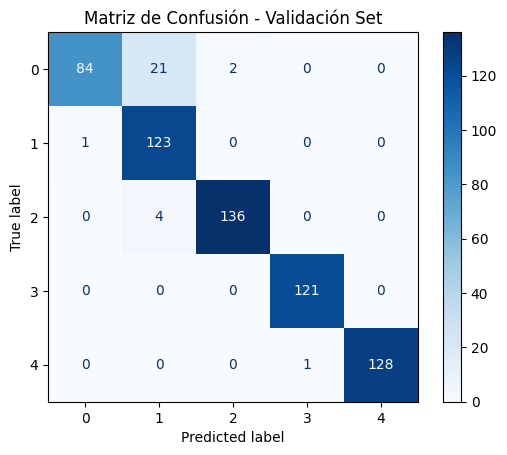

In [ ]:
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Validación Set")
plt.show()

# New version Dataset

In [ ]:
!ls

images	     resized_images		 ViT_predictions.csv
labels	     ViT_checkpoints_2025_06_17  ViT_train_stats.csv
new_version  ViT_checkpoints_2025_06_18  ViT_val_stats.csv


In [ ]:
df_train = pd.read_csv('new_version/labels/labels.csv')
print(df_train.shape)
df_test = pd.read_csv('new_version/labels/test.csv')
print(df_test.shape)

(2472, 5)
(245, 1)


In [ ]:
images_train = df_train['image_name'].tolist()
images_train = ['new_version/images/' + image for image in images_train]
print(len(images_train))

images_test = df_test['image_name'].tolist()
images_test_paths = ['new_version/images/' + image for image in images_test]
print(len(images_test_paths))

2472
245


In [ ]:
new_version_images_test_path = 'new_version/resized_images_test'
image_size = 224
for image in images_list:
    img = cv2.imread('images/' + image)
    h, w = img.shape[:2]

    # Factor de escala
    scale = image_size / max(h, w)

    # Resize
    img = cv2.resize(img, (int(w * scale), int(h * scale)))

    # Padding
    h_resized, w_resized = img.shape[:2]
    pad_top = (image_size - h_resized) // 2
    pad_bottom = image_size - h_resized - pad_top
    pad_left = (image_size - w_resized) // 2
    pad_right = image_size - w_resized - pad_left

    # Guardar imagen
    img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    cv2.imwrite(new_version_images_test_path + '/' + image, img)
    print(image)

In [ ]:
label_dict = {'nada':0, 'bajo':1, 'moderado':2, 'abundante':3, 'excesivo':4}
df_train['label_num'] = df_train['label'].map(label_dict)
images_train_label = df_train[['image_name', 'label_num']].values.tolist()

df_test['label_num'] = np.zeros(len(df_test))
images_test_label = df_test[['image_name', 'label_num']].values.tolist()

train_dataset = FilenameMappedDataset(images_train, images_train_label, transform=transform_fn)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = FilenameMappedDataset(images_test_paths, images_test_label, transform=transform_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test

## Cargar modelo

In [ ]:
fecha = '2025_06_17'
checkpoint_dir = f"ViT_checkpoints_{fecha}"


# Ruta del mejor modelo
best_model_path = os.path.join(checkpoint_dir, f"ViT_best_model_.pth")

# Cargar modelo
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
y_true = []
y_pred = []

# test_loader debe estar definido previamente
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
len(y_pred)

2472

In [ ]:
y_true = []
y_pred = []

# test_loader debe estar definido previamente
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
y_pred

array([1, 2, 3, 1, 0, 1, 4, 1, 2, 0, 1, 0, 2, 4, 0, 0, 2, 0, 1, 1, 2, 0,
       1, 0, 1, 0, 0, 1, 4, 2, 0, 1, 1, 0, 2, 4, 2, 4, 3, 0, 1, 2, 0, 3,
       0, 2, 4, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 4, 0, 2, 0, 1, 0, 1, 0,
       1, 0, 2, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 4, 4, 0,
       0, 3, 1, 0, 2, 1, 2, 1, 0, 0, 1, 1, 2, 0, 1, 2, 3, 1, 0, 4, 2, 0,
       0, 1, 4, 0, 1, 4, 1, 2, 1, 4, 1, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0,
       2, 1, 2, 3, 0, 3, 0, 0, 0, 0, 3, 2, 1, 0, 0, 2, 1, 0, 0, 1, 2, 1,
       0, 2, 1, 1, 4, 0, 2, 0, 4, 0, 0, 0, 0, 0, 1, 2, 1, 2, 4, 2, 0, 1,
       0, 4, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 3, 1, 1, 1,
       0, 0, 3, 4, 0, 3, 0, 3, 1, 0, 1, 1, 4, 0, 1, 0, 0, 3, 0, 4, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 2, 4, 2, 1, 0, 0, 1, 4, 0, 1, 0, 1, 0, 0,
       1, 0, 4])

In [ ]:
for img1, img2 in zip(images_test, df_test['image_name'].tolist()):
  if img1.split('/')[-1]!= img2:
    print('ERROR', img1)

In [ ]:
df_prediction = pd.DataFrame({'image_name': df_test['image_name'].tolist(), 'label': y_pred})
df_prediction.head()

,image_name,label
0,j0320.jpg,1
1,k0041.jpg,2
2,r106.jpg,3
3,s0420.jpg,1
4,k0863.jpg,0


In [ ]:
label_dict = {'nada':0, 'bajo':1, 'moderado':2, 'abundante':3, 'excesivo':4}
label_dict_inv = {0:'nada', 1:'bajo', 2:'moderado', 3:'abundante', 4:'excesivo'}
df_prediction['label'] = df_prediction['label'].map(label_dict_inv)
df_prediction.head()

,image_name,label
0,j0320.jpg,bajo
1,k0041.jpg,moderado
2,r106.jpg,abundante
3,s0420.jpg,bajo
4,k0863.jpg,nada


In [ ]:
print(df_prediction.shape)

(245, 2)


In [ ]:
csv_path = 'ViT_predictions_NewDataset.csv'
df_prediction.to_csv(csv_path, index=False)

In [ ]:
!ls

images		ViT_checkpoints_2025_06_17	ViT_train_stats.csv
labels		ViT_checkpoints_2025_06_18	ViT_val_stats.csv
new_version	ViT_predictions.csv
resized_images	ViT_predictions_NewDataset.csv
